In [230]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, Conv2D, MaxPool2D, AveragePooling2D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras import optimizers

In [231]:
root_folder = '/Users/kaiwang/bkup/har-keras-cnn/'

In [232]:
'''params'''
# n features
N_FEATURES = 3

# The number of steps within one time segment
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 1

filter_height = 3
filter_depths = [8, 8, 8, 16]
drop_out = 0.5

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 60

In [233]:
def read_data(file_path):
    df = pd.read_csv(file_path, index_col=[0])

    df_stock = df[df['minor'] == 'VMC'][['minor', 'Date', '0', '1', '2', 'f1d_label']]
    return df_stock


def create_segments_and_labels(df, time_steps, step, label_name):
    # Number of steps to advance in each iteration
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        feature_vals = []
        for j in range(N_FEATURES):
            feature_vals.append(df[str(j)].values[i: i + time_steps])

        # use last days f1d_binary as label
        label = df[label_name].values[i + time_steps - 1] * 1000

        segments.append(feature_vals)
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [234]:
df = read_data(root_folder + 'Data/temp_ret_3_30_stocks.csv')

# Define column name of the label vector
LABEL = 'f1d_label'

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['Date'] > '2019-02-24T09:30:00Z']
df_train = df[df['Date'] <= '2019-02-24T09:30:00Z']

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (134, 80, 3)
print(x_train.shape[0], 'training samples')
# Displays 134 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (134,)


--- Reshape the data into segments ---


--- Reshape data to be accepted by Keras ---

('x_train shape: ', (5360, 60, 3))
(5360, 'training samples')
('y_train shape: ', (5360,))


In [235]:
# Set input & output dimensions
num_time_periods, num_features = x_train.shape[1], x_train.shape[2]
num_classes = 2

# Set input_shape / reshape for Keras
# todo: remove
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [80,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods * num_features)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 240)
print('input_shape:', input_shape)
# input_shape: (240)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

('x_train shape:', (5360, 180))
('input_shape:', 180)


In [236]:
print("\n--- Create neural network model ---\n")

activation_func = 'relu'
# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_features), input_shape=(input_shape,)))  # 0
model_m.add(Conv1D(filter_depths[0], filter_height, activation=activation_func, input_shape=(TIME_PERIODS, num_features)))  # 1
model_m.add(Conv1D(filter_depths[1], filter_height, activation=activation_func))  # 2
model_m.add(AveragePooling1D(N_FEATURES))  # 3
# model_m.add(Conv1D(filter_depths[2], filter_height, activation=activation_func))  # 4
# model_m.add(Conv1D(filter_depths[3], filter_height, activation=activation_func))  # 5
model_m.add(GlobalAveragePooling1D())  # 6
# model_m.add(Dropout(drop_out))  # 7
model_m.add(Dense(20, activation=activation_func)) # 8
model_m.add(Dense(1))  # 9
print(model_m.summary())

# model_m.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_absolute_error')
model_m.compile(loss='mse', optimizer='adam', metrics=['mae'])

print("\n--- Fit the model ---\n")

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=root_folder + 'models_regression/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True)
#     keras.callbacks.EarlyStopping(monitor='acc', patience=3) # todo
]

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
#                       callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


--- Create neural network model ---

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 60, 3)             0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 58, 8)             80        
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 56, 8)             200       
_________________________________________________________________
average_pooling1d_18 (Averag (None, 18, 8)             0         
_________________________________________________________________
global_average_pooling1d_17  (None, 8)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 20)                180       
_________________________________________________________________
dense_37 (Dense)             (None, 1)

4288/4288 [==============================] - 0s 19us/step - loss: 15.0868 - mean_absolute_error: 2.0896 - val_loss: 3.6604 - val_mean_absolute_error: 1.4066
Epoch 42/60
4288/4288 [==============================] - 0s 20us/step - loss: 15.0875 - mean_absolute_error: 2.0892 - val_loss: 3.6555 - val_mean_absolute_error: 1.4047
Epoch 43/60
4288/4288 [==============================] - 0s 22us/step - loss: 15.0864 - mean_absolute_error: 2.0891 - val_loss: 3.6602 - val_mean_absolute_error: 1.4065
Epoch 44/60
4288/4288 [==============================] - 0s 24us/step - loss: 15.0861 - mean_absolute_error: 2.0896 - val_loss: 3.6631 - val_mean_absolute_error: 1.4075
Epoch 45/60
4288/4288 [==============================] - 0s 24us/step - loss: 15.0867 - mean_absolute_error: 2.0894 - val_loss: 3.6593 - val_mean_absolute_error: 1.4062
Epoch 46/60
4288/4288 [==============================] - 0s 24us/step - loss: 15.0867 - mean_absolute_error: 2.0899 - val_loss: 3.6655 - val_mean_absolute_error: 1.408

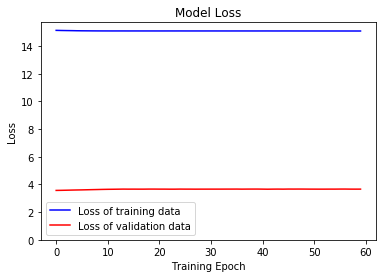

In [237]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], "b", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()

In [238]:
print(model_m.layers)

# print ('\ncheck layer before softmax output')
layer_models = []
for i in range(len(model_m.layers)):
    layer_models.append(Model(inputs=model_m.input, outputs=model_m.layers[i].output))

[<keras.layers.core.Reshape object at 0x11edd32d0>, <keras.layers.convolutional.Conv1D object at 0x11fd78ad0>, <keras.layers.convolutional.Conv1D object at 0x11fd78a90>, <keras.layers.pooling.AveragePooling1D object at 0x11e7bb0d0>, <keras.layers.pooling.GlobalAveragePooling1D object at 0x11fd78910>, <keras.layers.core.Dense object at 0x11fd65650>, <keras.layers.core.Dense object at 0x11f30c590>]


In [239]:
# x_test, y_test = create_segments_and_labels(df_test,
#                                             TIME_PERIODS,
#                                             STEP_DISTANCE,
#                                             LABEL)

# # Set input_shape / reshape for Keras
# # todo: remove
# x_test = x_test.reshape(x_test.shape[0], input_shape)

# x_test = x_test.astype("float32")
# y_test = y_test.astype("float32")

# score = model_m.evaluate(x_test, y_test, verbose=1)

# print('score:')
# print(score)

# y_pred_test = model_m.predict(x_test)

In [240]:
# plt.hist(y_pred_test)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 3.600e+01, 9.200e+01,
        7.420e+02, 2.942e+03, 1.220e+03, 2.090e+02, 6.900e+01, 1.200e+01,
        1.200e+01, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-40.53564835, -37.56790934, -34.60017033, -31.63243132,
        -28.66469231, -25.6969533 , -22.72921429, -19.76147528,
        -16.79373627, -13.82599726, -10.85825825,  -7.89051924,
         -4.92278023,  -1.95504122,   1.01269779,   3.9804368 ,
          6.94817581,   9.91591482,  12.88365383,  15.85139284,
         18.81913185,  21.78687086,  24.75460987,  27.72234888,
         30.69008789,  33.6578269 ,  36.62556591,  39.59330492,
         42.56104393,  45.52878294,  48.49652195,  51.

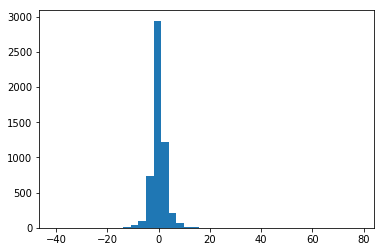

In [241]:
plt.hist(y_train, bins=40)

(array([5.21e+03, 8.20e+01, 8.00e+00, 0.00e+00, 2.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 3.00e+00,
        1.40e+01, 1.70e+01, 2.00e+00, 1.50e+01]),
 array([0.21375877, 0.21570181, 0.21764486, 0.21958791, 0.22153096,
        0.223474  , 0.22541705, 0.2273601 , 0.22930315, 0.23124619,
        0.23318924, 0.23513229, 0.23707533, 0.23901838, 0.24096143,
        0.24290448, 0.24484752, 0.24679057, 0.24873362, 0.25067667,
        0.25261971, 0.25456276, 0.25650581, 0.25844886, 0.2603919 ,
        0.26233495, 0.264278  , 0.26622104, 0.26816409, 0.27010714,
        0.27205019, 0.27399323, 0.27593628, 0.27787933, 0.27982238,
        0.28176542, 0.28370847, 0.28565152, 0.28759457, 0.28953761

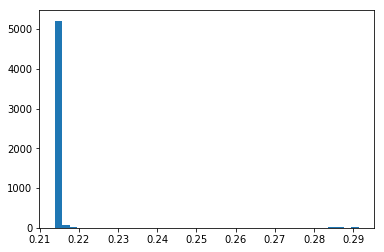

In [242]:
y_pred_train = model_m.predict(x_train)
plt.hist(y_pred_train, bins=40)

In [243]:
x_train

array([[-1.3388161e-03,  5.7268300e-04,  4.1940711e-03, ...,
        -7.7819551e-04, -3.9106567e-04, -5.2629597e-04],
       [ 5.7268300e-04,  4.1940711e-03,  2.6704816e-03, ...,
        -3.9106567e-04, -5.2629597e-04, -7.1479630e-04],
       [ 4.1940711e-03,  2.6704816e-03,  7.6299475e-04, ...,
        -5.2629597e-04, -7.1479630e-04,  7.5199277e-05],
       ...,
       [ 6.2344142e-04,  1.2461059e-03,  9.6145284e-04, ...,
         9.4097212e-04,  3.3691677e-03,  3.9588595e-03],
       [ 1.2461059e-03,  9.6145284e-04,  1.7809439e-04, ...,
         3.3691677e-03,  3.9588595e-03,  1.7702312e-03],
       [ 9.6145284e-04,  1.7809439e-04, -7.1256794e-04, ...,
         3.9588595e-03,  1.7702312e-03, -1.0833453e-05]], dtype=float32)